In [19]:
#import libraries
import pandas as pd
import random #use to generate data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# --- Constants and Configuration ---
CROP_VALUES = {
    'Soja': 3000, 'Milho': 2500, 'Arroz': 2000,
    'Feijão': 3500, 'Trigo': 1800, 'Aveia': 1500
}
JUNE_CROPS = [1,2,3,4] # 1 = 'Soja', 2 = 'Milho', 3 = 'Arroz', 4 = 'Feijão'
JANUARY_CROPS = [5,6] # 5 = 'Trigo', 6 = 'Aveia'
ALL_CROPS = JUNE_CROPS + JANUARY_CROPS
LOAN_TERMS = [180, 360] # Updated loan terms as per new requirements
MAX_LOANS_PER_YEAR = 3
MIN_LOAN_INTERVAL_DAYS = 30 # Minimum days between loans for the same client

# Hectar Constants
MIN_TOTAL_HECTAR_CLIENT = 50  # Minimum total hectares a client might own
MAX_TOTAL_HECTAR_CLIENT = 1000 # Maximum total hectares a client might own
# Percentage of client's total_hectares_client that can be taken for a SINGLE loan
MIN_LOAN_HECTAR_PORTION = 0.05
MAX_LOAN_HECTAR_PORTION = 0.50

# Maximum attempts to find an eligible client for a new loan in historic generation
MAX_ATTEMPTS_TO_FIND_CLIENT = 1000

In [3]:
# --- Helper Functions ---

def _calculate_loan_amount(hectar, culture):
    """Calculates loan amount based on hectares and crop type."""
    return round(hectar * CROP_VALUES.get(culture, 0), 2)

In [4]:
def _determine_rating(score):
    """Determines credit rating based on FICO score."""
    if score >= 750:
        return 5  # AAA
    elif score >= 700:
        return 4  # AA
    elif score >= 600:
        return 3  # A
    elif score >= 500:
        return 2  # B
    elif score >= 400:
        return 1  # C
    else:
        return 0  # D (High Risk)

In [5]:
def _simulate_score_change(current_score, had_previous_default):
    """Simulates score change for the NEXT loan based on previous default status."""
    if had_previous_default:
        # Score drops more significantly after a default
        score_change = random.randint(-120, -10) # Can drop by up to 120 points
    else:
        # Normal fluctuation, slight chance of increase/decrease
        score_change = random.randint(-20, 40) # Can increase slightly more than decrease

    new_score = max(200, min(850, current_score + score_change))
    return new_score

In [6]:
def _simulate_payment_delay_days(score, had_previous_default):
    """
    Simulates the number of days payment is delayed (can be negative for early payment).
    Lower score and previous default increase chance of delay.
    """
    delay_prob = 0
    if score < 400:
        delay_prob = 0.85 # High chance of significant delay
    elif score < 500:
        delay_prob = 0.60 # Moderate chance
    elif score < 600:
        delay_prob = 0.30 # Low chance
    elif score < 700:
        delay_prob = 0.10 # Low chance
    else:
        delay_prob = 0.02 # Very low chance

    if had_previous_default:
        delay_prob = min(1.0, delay_prob * 1.5) # Increase delay probability if previous default

    if random.random() < delay_prob:
        # Client delays payment
        if score < 400:
            return random.randint(20, 120) # More significant delay for lowest scores
        elif score < 500:
            return random.randint(10, 60)
        elif score < 600:
            return random.randint(5, 30)
        else:
            return random.randint(1, 15) # Small delay for higher scores
    else:
        # Client pays on time or early
        return random.randint(-10, 3) # Up to 10 days early, or 3 days late (still considered on time for this logic)

In [7]:
# --- Main Data Generation Functions ---

def generate_first_transactions(num_unique_clients: int):
    """
    Generates the first transaction for a specified number of unique clients.
    Returns a list of dictionaries and a dictionary of client states.
    """
    first_transactions_data = []
    # client_states now tracks hectares_used per season and their due dates
    client_states = {} 

    for i in range(num_unique_clients):
        client_id = f"CLIENT_{i:04d}"
        initial_score = random.randint(200, 850)
        total_hectares_client = round(random.uniform(MIN_TOTAL_HECTAR_CLIENT, MAX_TOTAL_HECTAR_CLIENT), 2)

        # Randomize initial loan date over a few years, ensuring it aligns with a crop month
        start_year = 2020 + random.randint(0, 3)
        initial_month = random.choice([1, 6]) # January or June
        loan_date = datetime(start_year, initial_month, random.randint(1, 28))

        income = round(random.uniform(5000, 500000), 2)
        culture = random.choice(JUNE_CROPS if initial_month == 6 else JANUARY_CROPS)

        # Hectar for this loan is a portion of total_hectares_client
        hectar = round(random.uniform(total_hectares_client * MIN_LOAN_HECTAR_PORTION,
                                     total_hectares_client * MAX_LOAN_HECTAR_PORTION), 2)
        hectar = max(1.0, min(hectar, total_hectares_client)) # Ensure hectar is valid

        loan_amount = _calculate_loan_amount(hectar, culture)
        loan_amount_term = random.choice(LOAN_TERMS)
        loan_due_date = loan_date + timedelta(days=loan_amount_term)

        # Simulate payment delay/early payment
        payment_delay_days = _simulate_payment_delay_days(initial_score, False) # No previous default for first loan
        payment_date = loan_due_date + timedelta(days=payment_delay_days)

        # Determine default status based on payment date vs due date
        default_status = 1 if payment_date > loan_due_date else 0

        rating = _determine_rating(initial_score)
        total_debt = round(random.uniform(loan_amount, min(loan_amount * 2, income * 3)), 2)
        # Explicitly ensure total_debt is not less than loan_amount (already handled by uniform, but reinforces rule)
        total_debt = max(total_debt, loan_amount)

        first_transactions_data.append({
            'id_client': client_id,
            'loan_date': loan_date.strftime('%Y-%m-%d'),
            'loan_due_date': loan_due_date.strftime('%Y-%m-%d'),
            'payment_date': payment_date.strftime('%Y-%m-%d'),
            'income': income,
            'culture': culture,
            'hectar': hectar,
            'total_hectares_client': total_hectares_client,
            'loan_amount': loan_amount,
            'loan_amount_term': loan_amount_term,
            'rating': rating,
            'score': initial_score,
            'total_debt': total_debt,
            'default_status': default_status,
            'transaction_type': 'first'
        })

        # Initialize client state for tracking hectares used per season
        client_states[client_id] = {
            'score': initial_score,
            'last_default_status': bool(default_status),
            'last_loan_date': loan_date,
            'loans_this_year': {loan_date.year: 1},
            'total_hectares_client': total_hectares_client,
            'hectares_used_june_season': hectar if culture in JUNE_CROPS else 0,
            'june_loan_due_date': loan_due_date if culture in JUNE_CROPS else None,
            'hectares_used_january_season': hectar if culture in JANUARY_CROPS else 0,
            'january_loan_due_date': loan_due_date if culture in JANUARY_CROPS else None,
        }
    return first_transactions_data, client_states

In [8]:
def generate_historic_transactions(
    first_transactions_data: list,
    client_states: dict,
    num_total_rows: int
):
    """
    Generates additional historic transactions, applying all new rules.
    """
    all_transactions_data = list(first_transactions_data)
    eligible_clients = list(client_states.keys())
    transactions_generated = len(first_transactions_data)
    
    attempts = 0 # To prevent infinite loops if clients run out of options

    while transactions_generated < num_total_rows and attempts < MAX_ATTEMPTS_TO_FIND_CLIENT * (num_total_rows - transactions_generated):
        client_id = random.choice(eligible_clients)
        client_state = client_states[client_id]
        
        # Advance loan_date realistically, ensuring it's after the last loan and in a valid month
        # Start a new transaction 1 month to 1 year after the last loan, plus random days
        base_future_date = client_state['last_loan_date'] + timedelta(days=random.randint(MIN_LOAN_INTERVAL_DAYS, 365))
        
        # Determine the month for the next loan (June or January)
        next_loan_month = random.choice([1, 6])
        
        # Set the loan_date to the determined month in the base_future_date's year
        loan_date = datetime(base_future_date.year, next_loan_month, random.randint(1, 28))

        # Ensure loan_date is always after the last loan for the same client
        if loan_date <= client_state['last_loan_date']:
            # If generated date is not sufficiently after last loan, push it forward
            loan_date = client_state['last_loan_date'] + timedelta(days=MIN_LOAN_INTERVAL_DAYS)
            # Re-adjust month if it changed and needs to be January/June
            if loan_date.month not in [1, 6]:
                loan_date = datetime(loan_date.year, next_loan_month, random.randint(1, 28))
                if loan_date <= client_state['last_loan_date']: # Ensure it's still after if year changed
                    loan_date = datetime(loan_date.year + 1, next_loan_month, random.randint(1, 28))

        # --- Free up hectares from matured loans ---
        if client_state['june_loan_due_date'] and loan_date > client_state['june_loan_due_date']:
            client_state['hectares_used_june_season'] = 0
            client_state['june_loan_due_date'] = None
        if client_state['january_loan_due_date'] and loan_date > client_state['january_loan_due_date']:
            client_state['hectares_used_january_season'] = 0
            client_state['january_loan_due_date'] = None

        # --- Check loan limits for the year ---
        current_year = loan_date.year
        client_state['loans_this_year'].setdefault(current_year, 0) # Ensure year is in dict

        if client_state['loans_this_year'][current_year] >= MAX_LOANS_PER_YEAR:
            attempts += 1
            continue # Try next client/iteration

        # --- Determine available hectares for new loan based on season ---
        culture = random.choice(JUNE_CROPS if loan_date.month == 6 else JANUARY_CROPS)
        is_june_season_loan = culture in JUNE_CROPS
        
        if is_june_season_loan:
            available_hectares_for_this_loan = client_state['total_hectares_client'] - client_state['hectares_used_june_season']
            # If there's an active loan for the same season, ensure it's truly free
            if client_state['hectares_used_june_season'] > 0 and client_state['june_loan_due_date'] and loan_date <= client_state['june_loan_due_date']:
                # Loan for this season is still active, cannot take another one for the same season
                attempts += 1
                continue
        else: # January season loan
            available_hectares_for_this_loan = client_state['total_hectares_client'] - client_state['hectares_used_january_season']
            # If there's an active loan for the same season, ensure it's truly free
            if client_state['hectares_used_january_season'] > 0 and client_state['january_loan_due_date'] and loan_date <= client_state['january_loan_due_date']:
                # Loan for this season is still active, cannot take another one for the same season
                attempts += 1
                continue
        
        if available_hectares_for_this_loan < 1.0: # Need at least 1 hectare to make a loan
            attempts += 1
            continue

        # --- Determine hectar for the new loan ---
        hectar = round(random.uniform(available_hectares_for_this_loan * MIN_LOAN_HECTAR_PORTION,
                                     available_hectares_for_this_loan * MAX_LOAN_HECTAR_PORTION), 2)
        hectar = max(1.0, min(hectar, available_hectares_for_this_loan)) # Ensure valid range

        if hectar < 1.0: # Minimum hectare for a loan
            attempts += 1
            continue

        # --- Generate other transaction details ---
        current_score_for_this_loan = _simulate_score_change(client_state['score'], client_state['last_default_status'])
        client_state['score'] = current_score_for_this_loan # Update client's score for future transactions

        income = round(random.uniform(5000, 500000), 2)
        loan_amount = _calculate_loan_amount(hectar, culture)
        loan_amount_term = random.choice(LOAN_TERMS)
        loan_due_date = loan_date + timedelta(days=loan_amount_term)

        payment_delay_days = _simulate_payment_delay_days(current_score_for_this_loan, client_state['last_default_status'])
        payment_date = loan_due_date + timedelta(days=payment_delay_days)

        default_status = 1 if payment_date > loan_due_date else 0
        rating = _determine_rating(current_score_for_this_loan)
        total_debt = round(random.uniform(loan_amount, min(loan_amount * 2, income * 3)), 2)
        total_debt = max(total_debt, loan_amount) # Ensure total_debt is not less than loan_amount

        # --- Update client state after successful loan generation ---
        client_state['last_default_status'] = bool(default_status)
        client_state['last_loan_date'] = loan_date
        client_state['loans_this_year'][current_year] += 1

        if is_june_season_loan:
            client_state['hectares_used_june_season'] = hectar
            client_state['june_loan_due_date'] = loan_due_date
        else:
            client_state['hectares_used_january_season'] = hectar
            client_state['january_loan_due_date'] = loan_due_date

        all_transactions_data.append({
            'id_client': client_id,
            'loan_date': loan_date.strftime('%Y-%m-%d'),
            'loan_due_date': loan_due_date.strftime('%Y-%m-%d'),
            'payment_date': payment_date.strftime('%Y-%m-%d'),
            'income': income,
            'culture': culture,
            'hectar': hectar,
            'total_hectares_client': client_state['total_hectares_client'],
            'loan_amount': loan_amount,
            'loan_amount_term': loan_amount_term,
            'rating': rating,
            'score': current_score_for_this_loan,
            'total_debt': total_debt,
            'default_status': default_status,
            'transaction_type': 'historic'
        })
        transactions_generated += 1
        attempts = 0 # Reset attempts after a successful transaction

    if transactions_generated < num_total_rows:
        print(f"Warning: Could only generate {transactions_generated} rows out of {num_total_rows} due to client eligibility constraints and max attempts.")

    return all_transactions_data


In [9]:
# --- Execution ---

def main(num_total_rows: int = 20000, num_unique_clients: int = 1000):
    """
    Main function to orchestrate data generation and return DataFrames.
    """
    print(f"Generating {num_unique_clients} first transactions...")
    first_transactions_list, client_states = generate_first_transactions(num_unique_clients)
    df_first_transactions = pd.DataFrame(first_transactions_list)

    print(f"Generating {num_total_rows - num_unique_clients} historic transactions...")
    all_transactions_list = generate_historic_transactions(
        first_transactions_list,
        client_states,
        num_total_rows
    )
    df_historic_transactions = pd.DataFrame(all_transactions_list)

    # Convert date columns to datetime objects for proper sorting and analysis
    df_historic_transactions['loan_date'] = pd.to_datetime(df_historic_transactions['loan_date'])
    df_historic_transactions['loan_due_date'] = pd.to_datetime(df_historic_transactions['loan_due_date'])
    df_historic_transactions['payment_date'] = pd.to_datetime(df_historic_transactions['payment_date'])
    
    # Sort historic transactions by client and date to ensure chronological order
    df_historic_transactions = df_historic_transactions.sort_values(by=['id_client', 'loan_date']).reset_index(drop=True)

    print("\nData generation complete!")
    print(f"First transactions DataFrame has '{len(df_first_transactions)}' rows.")
    print(f"Historic transactions DataFrame has '{len(df_historic_transactions)}' rows.")


    return df_first_transactions, df_historic_transactions

In [10]:
# Generate 20,000 rows
# You can adjust the total number of rows and unique clients here
df_first, df_historic = main(num_total_rows=20000, num_unique_clients=8000)


Generating 8000 first transactions...
Generating 12000 historic transactions...

Data generation complete!
First transactions DataFrame has '8000' rows.
Historic transactions DataFrame has '20000' rows.


In [11]:
# df_credit.describe()
# df_credit.head()
df_historic.head()

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status,transaction_type
0,CLIENT_0000,2021-01-12,2021-07-11,2021-07-05,85985.63,5,238.62,561.19,0.0,180,4,706,0.0,0,first
1,CLIENT_0000,2021-06-16,2022-06-11,2022-06-09,252711.77,1,43.45,561.19,0.0,360,4,714,0.0,0,historic
2,CLIENT_0000,2022-01-08,2023-01-03,2023-01-03,141187.65,6,146.15,561.19,0.0,360,4,739,0.0,0,historic
3,CLIENT_0001,2023-01-12,2023-07-11,2023-07-12,311045.15,5,3.91,70.53,0.0,180,4,714,0.0,1,first
4,CLIENT_0001,2023-06-23,2023-12-20,2023-12-19,204927.74,2,20.97,70.53,0.0,180,3,677,0.0,0,historic


In [12]:
# df_historic.to_excel('historic.xlsx', index=False, sheet_name='Sheet1')

In [34]:
# Filter clients who have ever defaulted (default_status == 1)
clients_with_default = df_historic[df_historic['default_status'] == 1]['id_client'].unique()
df_historic[df_historic['id_client'].isin(clients_with_default)]

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status,transaction_type
3,CLIENT_0001,2023-01-12,2023-07-11,2023-07-12,311045.15,5,3.91,70.53,0.0,180,4,714,0.0,1,first
4,CLIENT_0001,2023-06-23,2023-12-20,2023-12-19,204927.74,2,20.97,70.53,0.0,180,3,677,0.0,0,historic
5,CLIENT_0001,2024-01-28,2024-07-26,2024-07-26,403112.91,6,5.02,70.53,0.0,180,3,665,0.0,0,historic
6,CLIENT_0001,2025-01-25,2025-07-24,2025-07-21,164757.59,5,14.21,70.53,0.0,180,3,691,0.0,0,historic
7,CLIENT_0001,2026-01-05,2026-07-04,2026-07-07,105479.58,5,9.15,70.53,0.0,180,3,674,0.0,1,historic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,CLIENT_7997,2023-06-11,2023-12-08,2023-12-09,280214.11,1,14.25,59.64,0.0,180,4,748,0.0,1,historic
19996,CLIENT_7998,2022-01-15,2023-01-10,2023-02-08,73144.08,5,76.05,246.90,0.0,360,2,511,0.0,1,first
19997,CLIENT_7998,2022-06-06,2023-06-01,2023-07-15,264109.52,3,57.77,246.90,0.0,360,1,473,0.0,1,historic
19998,CLIENT_7999,2022-06-12,2023-06-07,2023-06-09,299955.79,2,107.57,312.83,0.0,360,2,538,0.0,1,first


In [14]:

# clear dataset to remove null data
df_credit_clear = df_historic.dropna()
df_credit_clear = df_credit_clear.drop(columns=['transaction_type','loan_date', 'loan_due_date', 'payment_date'])
df_credit_clear.count()

id_client                20000
income                   20000
culture                  20000
hectar                   20000
total_hectares_client    20000
loan_amount              20000
loan_amount_term         20000
rating                   20000
score                    20000
total_debt               20000
default_status           20000
dtype: int64

In [15]:
# transform id_client to int
df_credit_clear['id_client'] = df_credit_clear['id_client'].str.replace('CLIENT_', '').astype(int)

In [ ]:
# Analyze the correlation between numeric columns
df_credit_clear.corr()

,id_client,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status
id_client,1.000000,0.003086,0.010649,-0.005585,-0.001131,NaN,-0.000134,-0.008213,-0.008849,NaN,0.004720
income,0.003086,1.000000,-0.002017,-0.007007,0.000313,NaN,0.004342,0.001114,-0.001052,NaN,0.001648
culture,0.010649,-0.002017,1.000000,0.002215,0.001511,NaN,-0.002714,0.000538,0.000310,NaN,0.002598
hectar,-0.005585,-0.007007,0.002215,1.000000,0.697121,NaN,-0.002473,-0.001569,-0.002237,NaN,-0.002050
total_hectares_client,-0.001131,0.000313,0.001511,0.697121,1.000000,NaN,0.005068,0.000170,0.000959,NaN,-0.005504
loan_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amount_term,-0.000134,0.004342,-0.002714,-0.002473,0.005068,NaN,1.000000,0.004270,0.005941,NaN,-0.004728
rating,-0.008213,0.001114,0.000538,-0.001569,0.000170,NaN,0.004270,1.000000,0.963644,NaN,-0.616943
score,-0.008849,-0.001052,0.000310,-0.002237,0.000959,NaN,0.005941,0.963644,1.000000,NaN,-0.621624
total_debt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# df_credit_clear.sort_values(by="rating", ascending=True).head()
df_credit_clear.describe()
# df_credit_clear.columns

,id_client,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3991.642550,251374.848859,3.900950,141.959152,519.648921,0.0,269.568000,1.842200,495.680900,0.0,0.614350
std,2313.315744,143001.431488,1.740974,106.961021,275.567131,0.0,90.001213,1.836918,206.602857,0.0,0.486761
min,0.000000,5053.000000,1.000000,2.530000,50.220000,0.0,180.000000,0.000000,200.000000,0.0,0.000000
25%,1988.750000,128813.520000,2.000000,54.637500,284.810000,0.0,180.000000,0.000000,303.750000,0.0,0.000000
50%,3989.000000,250697.000000,4.000000,113.920000,512.100000,0.0,180.000000,1.000000,495.000000,0.0,1.000000
75%,5983.000000,374903.867500,5.000000,207.642500,757.122500,0.0,360.000000,3.000000,680.000000,0.0,1.000000
max,7999.000000,499945.950000,6.000000,493.360000,999.980000,0.0,360.000000,5.000000,850.000000,0.0,1.000000


In [17]:
#Split dataset into features and target variable
dt_x = df_credit_clear.iloc[:, :-1]
dt_y = df_credit_clear.iloc[:, -1]

In [18]:
#Split the dataset into temporary and testing sets
dt_x_temp, dt_x_test, dt_y_temp, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

In [19]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA()),
    ('classifier', RandomForestClassifier())])

pc = pipe.fit(dt_x_temp, dt_y_temp)

pc

,steps,"[('scaler', ...), ('reducer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


In [20]:
y_pred = pipe.predict(dt_x_test)
accuracy_score(dt_y_test, y_pred)

0.79025

In [37]:
target_name = ['class 0','class 1']
print(classification_report(dt_y_test, y_pred, target_names=target_name))

              precision    recall  f1-score   support

     class 0       0.70      0.81      0.75      1545
     class 1       0.86      0.78      0.82      2455

    accuracy                           0.79      4000
   macro avg       0.78      0.79      0.78      4000
weighted avg       0.80      0.79      0.79      4000



Testes com o random search

In [21]:
max_depths_list = np.arange(1,101) # Odd numbers from 1 to 100

masx_features = np.linspace(0.001, 0.5, 100)

parameter_grid = {
    'max_depth': max_depths_list,
    'max_features': masx_features}

number_iterations = 10

grid = RandomizedSearchCV(estimator=RandomForestClassifier(),
                         param_distributions=parameter_grid,
                         scoring='accuracy',
                         n_iter=number_iterations,
                         return_train_score=True)

grid.fit(dt_x_temp, dt_y_temp)

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': array([ 1, ...98, 99, 100]), 'max_features': array([0.001 ..., 0.5 ])}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


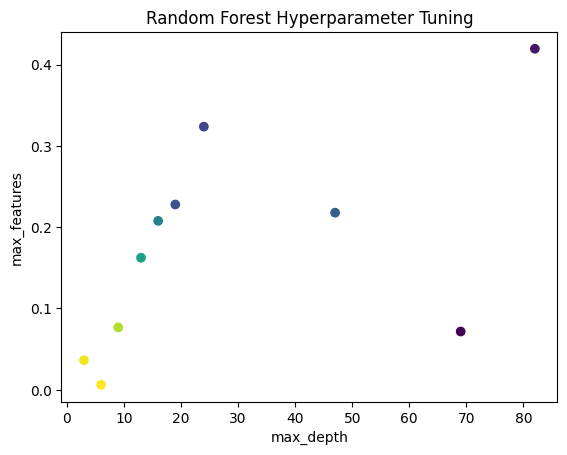

In [22]:
tested_x = list(grid.cv_results_['param_max_depth'])
tested_y = list(grid.cv_results_['param_max_features'])

plt.scatter(tested_x, tested_y, c=grid.cv_results_['mean_test_score'], cmap='viridis')
plt.gca().set(xlabel='max_depth', ylabel='max_features', title='Random Forest Hyperparameter Tuning')
plt.show()

In [23]:
grid.best_index_

np.int64(8)

In [24]:
grid.best_params_

{'max_features': np.float64(0.0060404040404040404), 'max_depth': np.int64(6)}

In [25]:
grid.best_score_

np.float64(0.8035625)

In [26]:
predictions = grid.predict(dt_x_test)
print(accuracy_score(dt_y_test, predictions))

0.79225


Test to validate models

In [27]:
#example to test hiperparameters on Random Forest
max_depths_list = [5,10]

In [28]:
hyperparameter_avg_metric = []
metric_log = []

In [29]:
for max_depth in max_depths_list:
    print(f"Testing max_depth: {max_depth}")
    # Create a Random Forest model with the current max_depth
    rf_model = RandomForestClassifier(max_depth=max_depth)
    
    model_metrics = []

    # Perform cross-validation
    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(dt_x_temp)
    
    for train_index, validate_index in splits:
        X_train, X_validate = dt_x_temp.iloc[train_index], dt_x_temp.iloc[validate_index]
        y_train, y_validate = dt_y_temp.iloc[train_index], dt_y_temp.iloc[validate_index]

        # Fit the model
        rf_model.fit(X_train, y_train)

        # Predict on the validation set
        predictions = rf_model.predict(X_validate)

        # Calculate accuracy
        model_metrics.append( accuracy_score(y_validate, predictions))
        metric_log.append(accuracy_score(y_validate, predictions))

    hyperparameter_avg_metric.append(np.mean(model_metrics))

Testing max_depth: 5
Testing max_depth: 10


In [30]:
metric_log

[0.809375,
 0.813125,
 0.799375,
 0.805625,
 0.795625,
 0.81625,
 0.799375,
 0.791875,
 0.809375,
 0.7925,
 0.800625,
 0.785625,
 0.80625,
 0.799375,
 0.821875,
 0.809375,
 0.79125,
 0.79375,
 0.7975,
 0.796875]

In [31]:
hyperparameter_avg_metric

[np.float64(0.80325), np.float64(0.8002500000000001)]

In [32]:
model = RandomForestClassifier()

cv_results = cross_val_score(model, dt_x_temp, dt_y_temp, cv=10, scoring='accuracy')
cv_results

array([0.803125, 0.795   , 0.771875, 0.798125, 0.805625, 0.79875 ,
       0.79    , 0.80375 , 0.795625, 0.78875 ])

In [59]:
# clear dataset to remove null data
df_credit_clear = df_historic.dropna()
# transform id_client to int
df_credit_clear['id_client'] = df_credit_clear['id_client'].str.replace('CLIENT_', '').astype(int)

df_credit_clear.describe()

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status
count,20000.000000,20000,20000,20000,20000.000000,20000.00000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3978.517450,2022-06-14 15:03:10.080000,2023-03-11 19:09:24.480000,2023-04-08 09:58:45.120000,252437.923388,3.91955,145.105190,528.002855,0.0,270.171000,1.818300,493.716000,0.0,0.617450
min,0.000000,2020-01-01 00:00:00,2020-06-29 00:00:00,2020-06-21 00:00:00,5007.390000,1.00000,3.050000,50.050000,0.0,180.000000,0.000000,200.000000,0.0,0.000000
25%,1980.000000,2021-06-08 00:00:00,2022-01-09 00:00:00,2022-02-13 00:00:00,128810.907500,2.00000,56.697500,288.940000,0.0,180.000000,0.000000,304.000000,0.0,0.000000
50%,3963.000000,2022-06-12 00:00:00,2023-01-16 00:00:00,2023-03-18 00:00:00,251777.275000,4.00000,116.820000,529.295000,0.0,360.000000,1.000000,494.000000,0.0,1.000000
75%,5970.250000,2023-06-12 06:00:00,2024-01-18 00:00:00,2024-03-26 00:00:00,377568.240000,5.00000,211.645000,766.550000,0.0,360.000000,3.000000,673.000000,0.0,1.000000
max,7999.000000,2028-06-20 00:00:00,2029-06-15 00:00:00,2029-08-31 00:00:00,499980.160000,6.00000,496.010000,999.980000,0.0,360.000000,5.000000,850.000000,0.0,1.000000
std,2306.814854,NaN,NaN,NaN,143316.285461,1.73883,108.185046,274.560506,0.0,90.002088,1.815695,204.883783,0.0,0.486022



--- Preprocessing ---

In [40]:
# Convert date columns to datetime objects
date_cols = ['loan_date', 'loan_due_date', 'payment_date']
for col in date_cols:
    df_credit_clear[col] = pd.to_datetime(df_credit_clear[col])

# Calculate loan duration and days to payment
df_credit_clear['loan_duration_days'] = (df_credit_clear['loan_due_date'] - df_credit_clear['loan_date']).dt.days
df_credit_clear['days_to_payment'] = (df_credit_clear['payment_date'] - df_credit_clear['loan_due_date']).dt.days

# Handle missing values
# For numerical columns, fill with median
numerical_cols = df_credit_clear.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    if df_credit_clear[col].isnull().any():
        df_credit_clear[col] = df_credit_clear[col].fillna(df_credit_clear[col].median())

# For categorical columns, fill with mode or 'Unknown'
categorical_cols = df_credit_clear.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    print(f"Processing column: {col}")
    if df_credit_clear[col].isnull().any():
        df_credit_clear[col] = df_credit_clear[col].fillna(df_credit_clear[col].mode()[0]) # Using mode for simplicity


Processing column: transaction_type


In [48]:
# Encode categorical features
# Label Encoding for 'culture'
le_culture = LabelEncoder()
df_credit_clear['culture_encoded'] = le_culture.fit_transform(df_credit_clear['culture'])

# One-Hot Encoding for 'transaction_type'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
transaction_type_encoded = ohe.fit_transform(df_credit_clear[['transaction_type']])
transaction_type_df = pd.DataFrame(transaction_type_encoded, columns=ohe.get_feature_names_out(['transaction_type']))
df = pd.concat([df_credit_clear.reset_index(drop=True), transaction_type_df], axis=1)

# Target variable encoding: 'default_status' (0 or 1)
df['default_status'] = df['default_status'].astype(int)

# --- Prepare Data for Traditional ML (Latest Transaction per Client) ---
# Sort by client and loan_date to ensure we pick the latest transaction
df_sorted = df.sort_values(by=['id_client', 'loan_date'])

# Get the last (most recent) transaction for each client
# This assumes we want to predict the default status of the *next* loan based on the most recent historical data.
# If a client has multiple entries, we take the one with the latest `loan_date`.
latest_transactions = df_sorted.groupby('id_client').tail(1).reset_index(drop=True)

print("\nDataFrame with latest transaction per client:")
print(latest_transactions.head())
print(latest_transactions.info())



DataFrame with latest transaction per client:
   id_client  loan_date loan_due_date payment_date     income  culture  \
0          0 2022-01-08    2023-01-03   2023-01-03  141187.65        6   
1          1 2026-01-05    2026-07-04   2026-07-07  105479.58        5   
2          2 2020-06-09    2021-06-04   2021-06-07   78378.80        4   
3          3 2023-06-06    2024-05-31   2024-05-27   71274.31        1   
4          4 2023-01-21    2023-07-20   2023-07-11  455546.99        5   

   hectar  total_hectares_client  loan_amount  loan_amount_term  rating  \
0  146.15                 561.19          0.0               360       4   
1    9.15                  70.53          0.0               180       3   
2  220.91                 509.72          0.0               360       3   
3  197.49                 844.36          0.0               360       4   
4  399.66                 916.97          0.0               180       4   

   score  total_debt  default_status transaction_type  lo

In [51]:
# Select features for the Random Forest model
# Exclude original categorical columns, date columns, and id_client
features = [ 'id_client',
    'income', 'hectar', 'total_hectares_client', 'loan_amount',
    'loan_amount_term', 'rating', 'score', 'total_debt',
    'loan_duration_days', 'days_to_payment', 'culture_encoded',
    'transaction_type_first', 'transaction_type_historic'
]

X = latest_transactions[features]
y = latest_transactions['default_status']

print(X)

      id_client     income  hectar  total_hectares_client  loan_amount  \
0             0  141187.65  146.15                 561.19          0.0   
1             1  105479.58    9.15                  70.53          0.0   
2             2   78378.80  220.91                 509.72          0.0   
3             3   71274.31  197.49                 844.36          0.0   
4             4  455546.99  399.66                 916.97          0.0   
...         ...        ...     ...                    ...          ...   
7995       7995   62485.26  112.54                 539.31          0.0   
7996       7996  249754.63   78.61                 176.29          0.0   
7997       7997  280214.11   14.25                  59.64          0.0   
7998       7998  264109.52   57.77                 246.90          0.0   
7999       7999  197000.39  124.08                 312.83          0.0   

      loan_amount_term  rating  score  total_debt  loan_duration_days  \
0                  360       4    739 

In [ ]:

# Standardize numerical features
# Fit scaler only on training data later, but for now, fit on X to get the transformation
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# --- Train-Test Split (Client-wise) ---
# We still need to ensure that clients in the training set are not in the test set.
# Since `latest_transactions` already has one row per client, we can split directly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain class distribution

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (6400, 14), y_train shape: (6400,)
X_test shape: (1600, 14), y_test shape: (1600,)


C:\Users\CF G\AppData\Local\Temp\ipykernel_18252\87803644.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features])


In [44]:
# --- Build and Train the Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' handles class imbalance
rf_model.fit(X_train, y_train)

# --- Evaluate the Model ---
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probability of the positive class (default)

print("\n--- Model Evaluation (Random Forest) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Model Evaluation (Random Forest) ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       572
           1       1.00      1.00      1.00      1028

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600




Confusion Matrix:
[[ 572    0]
 [   0 1028]]


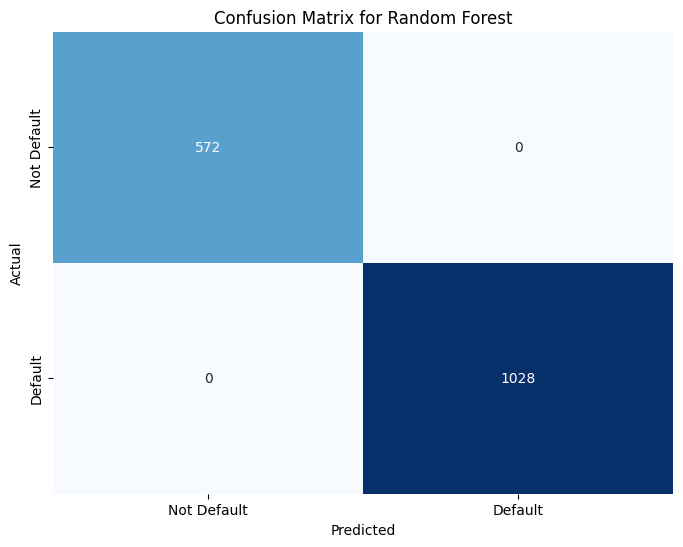

In [45]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


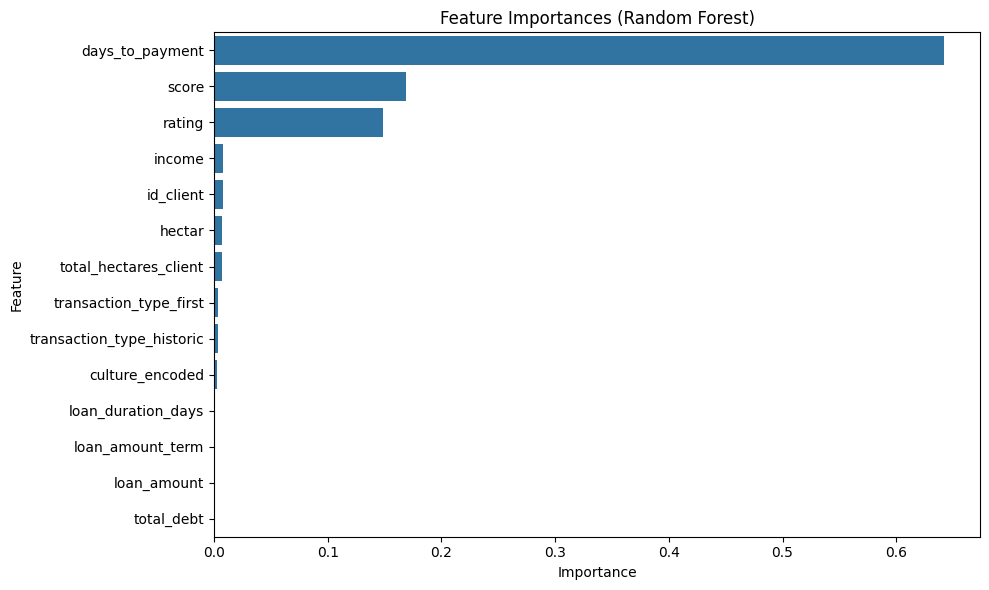

In [46]:
# --- Feature Importance ---
importances = rf_model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances, y=forest_importances.index)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [47]:

print("\n--- Next Steps ---")
print("This script successfully implemented a Random Forest Classifier to predict client loan default status.")
print("Key steps included:")
print("1. Data loading and initial cleaning.")
print("2. Feature engineering (loan duration, days to payment).")
print("3. Categorical feature encoding (LabelEncoder for 'culture', OneHotEncoder for 'transaction_type').")
print("4. Preparation of data by selecting the *latest* transaction for each client, suitable for traditional ML models.")
print("5. Numerical feature standardization.")
print("6. Client-wise train-test split to prevent data leakage.")
print("7. Random Forest model building, training, and evaluation.")
print("8. Visualization of Confusion Matrix and Feature Importances.")

print("\nFurther improvements and considerations:")
print("1. **Handling Imbalanced Data**: Although `class_weight='balanced'` was used, further techniques like SMOTE or different sampling strategies could be explored if the imbalance is severe.")
print("2. **Hyperparameter Tuning**: Optimize the Random Forest (e.g., `n_estimators`, `max_depth`, `min_samples_split`) using GridSearchCV or RandomizedSearchCV.")
print("3. **Cross-validation**: Implement k-fold cross-validation for more robust model evaluation.")
print("4. **Time-Series Features**: While this model uses the latest transaction, you could engineer more sophisticated time-series features (e.g., average income over last 3 loans, trend of total debt) if you want to capture more historical context for a non-sequential model.")
print("5. **Other Models**: Experiment with Gradient Boosting Machines (XGBoost, LightGBM) which often perform very well on tabular data.")
print("6. **Prediction for New Clients**: To predict for a new client, you would preprocess their latest transaction data in the same way (feature engineering, encoding, scaling) and then pass it to the trained `rf_model.predict()` or `rf_model.predict_proba()` method.")



--- Next Steps ---
This script successfully implemented a Random Forest Classifier to predict client loan default status.
Key steps included:
1. Data loading and initial cleaning.
2. Feature engineering (loan duration, days to payment).
3. Categorical feature encoding (LabelEncoder for 'culture', OneHotEncoder for 'transaction_type').
4. Preparation of data by selecting the *latest* transaction for each client, suitable for traditional ML models.
5. Numerical feature standardization.
6. Client-wise train-test split to prevent data leakage.
7. Random Forest model building, training, and evaluation.
8. Visualization of Confusion Matrix and Feature Importances.

Further improvements and considerations:
1. **Handling Imbalanced Data**: Although `class_weight='balanced'` was used, further techniques like SMOTE or different sampling strategies could be explored if the imbalance is severe.
2. **Hyperparameter Tuning**: Optimize the Random Forest (e.g., `n_estimators`, `max_depth`, `min_sampl